In [1]:
import ast
import time
from pathlib import Path

import camb
import matplotlib.pyplot as plt
import numpy as np
import sacc
from astropy.io import fits
from camb.correlations import lensed_cl_derivatives
from cobaya.model import get_model
from cobaya.tools import resolve_packages_path
from cobaya.yaml import yaml_load_file

try:
    from numpy import trapezoid
except ImportError:
    from numpy import trapz as trapezoid

# Computing derivatives of CMB power spectra wrt lensing potential

In [2]:
custom_packages_path = None

# Try to resolve global path
if custom_packages_path is None:
    packages_path = resolve_packages_path()
else:
    packages_path = custom_packages_path

# Try to resolve global path
if custom_packages_path is None:
    packages_path = resolve_packages_path()

In [3]:
# Load CMB temperature/polarization data, covariance and bandpowers

s = sacc.Sacc.load_fits(
    packages_path + "/data/MFLike/v0.8/data_sacc_w_covar_and_Bbl.fits"
)

In [4]:
# Extract cosmological parameters, fsky, lmax

fsky = float(s.metadata["f_sky_LAT"])
cosmo = ast.literal_eval(s.metadata["cosmo_params"])
cosmomc_theta = cosmo["cosmomc_theta"]
As = 1e-10 * np.exp(cosmo["logA"])
ombh2 = cosmo["ombh2"]
omch2 = cosmo["omch2"]
ns = cosmo["ns"]
Alens = cosmo["Alens"]
tau = cosmo["tau"]

lmax_CMB = int(s.metadata["lmax"]) + 1
accuracy_dic = ast.literal_eval(s.metadata['accuracy_params'])

In [5]:
# Compute power spectra with CAMB, required to then compute derivatives

pars = camb.set_params(
    ombh2=ombh2,
    omch2=omch2,
    cosmomc_theta=cosmomc_theta,
    tau=tau,
    As=As,
    ns=ns,
    Alens=Alens,
    lmax = lmax_CMB,
    lens_potential_accuracy = accuracy_dic['lens_potential_accuracy'],
    lens_margin = accuracy_dic['lens_margin'],
    AccuracyBoost = accuracy_dic['AccuracyBoost'],
    lSampleBoost = accuracy_dic['lSampleBoost'],
    lAccuracyBoost = accuracy_dic['lAccuracyBoost'],
    kmax = accuracy_dic['kmax'],
    k_per_logint = accuracy_dic['k_per_logint'],
    nonlinear = accuracy_dic['nonlinear'],
    DoLateRadTruncation = accuracy_dic['DoLateRadTruncation'],
)


pars.set_for_lmax(lmax_CMB)
results = camb.get_results(pars)
cls = results.get_unlensed_total_cls(CMB_unit="muK")[0 : lmax_CMB + 1, :]
clp = results.get_lens_potential_cls(CMB_unit="muK")[0 : lmax_CMB + 1, 0]

In [6]:
# Compute derivatives, takes about 5mn to run

t1 = time.time()
dCllens = lensed_cl_derivatives(cls, clp)
t2 = time.time()
print(t2 - t1)

257.1536524295807


In [7]:
np.save("products/dCllens.npy", dCllens)

# Cross-covariance CMB primary - CMB lensing

In [8]:
# Load fiducial lensing yaml file
yaml_folder = '../../../examples/smooth/yamls/'
yaml_path = Path(yaml_folder)
info = yaml_load_file(yaml_folder+"run_lensing_fiducial.yaml")

model = get_model(info)
params_values = model.parameterization.input_params()
model.loglikes(params_values)
lenslike = model.likelihood['soliket.LensingLikelihood']


2025-11-19 12:06:22.622463: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 12:06:25.052687: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 12:06:25.091986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 12:07:25.594824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[camb] `camb` module loaded successfully from /mnt/lustre/users/astro/rk480/miniforge3/envs/pyccl-mpi/lib/python3.11/site-packages/camb
[soliket.lensinglikelihood] Initialising.
[camb] `camb` module loaded successfully from /mnt/lustre/users/astro/rk480/miniforge3/envs/pyccl-mpi/lib/python3.11/site-packages/camb


In [9]:
lmax_kk = len(lenslike.binning_matrix[0])
nb_bins_kk = len(lenslike.binning_matrix)
ell_kk = np.arange(lmax_kk)
ell_kk_center = lenslike.bin_centers
cl_kk_fid = np.pi / 2 * lenslike.provider.get_Cl(ell_factor=True)['pp'][0:lmax_kk]

In [10]:
# Compute cross-covariance matrix between l(l+1)/(2*pi)C_l^{TT,EE,TE} and C_l^{kk} 
# (no prefactor before C_l^{kk})

XCov_binned = np.zeros((s.mean.size, nb_bins_kk))

index_cmb = 0
for comb in s.get_tracer_combinations():
    (t1, t2) = comb
    if t1[-1] == "0" and t2[-1] == "0":
        # TT case
        ind = s.indices("cl_00", comb)
        ind_CAMB = 0
    elif t1[-1] == "2" and t2[-1] == "2":
        # EE case
        ind = s.indices("cl_ee", comb)
        ind_CAMB = 1
    else:
        # TE case
        ind = s.indices("cl_0e", comb)
        ind_CAMB = 3

    bpw = s.get_bandpower_windows(ind)
    w = bpw.weight.T  # Shape (k, ell)

    # Compute cross-covariance
    XCov = 2/np.pi* dCllens[ind_CAMB, bpw.values, :lmax_kk]/clp[0:lmax_kk] \
            *2*cl_kk_fid**2/(2*ell_kk+1)/fsky
    XCov[:,0:2] = [0,0]

    # Bin cross-covariance
    for j in range(nb_bins_kk):
        w_kk = lenslike.binning_matrix[j]
        XCov_binned[index_cmb:index_cmb + len(w), j] = w @ np.sum(w_kk * XCov, axis=1)

    index_cmb += len(w)


In [11]:
import copy

XCorr = copy.deepcopy(XCov_binned)
for k in range(len(XCorr)):
    for j in range(len(XCorr[0])):
        XCorr[k,j] = XCov_binned[k,j]/np.sqrt(lenslike.cov[j,j]*s.covariance.covmat[k,k])

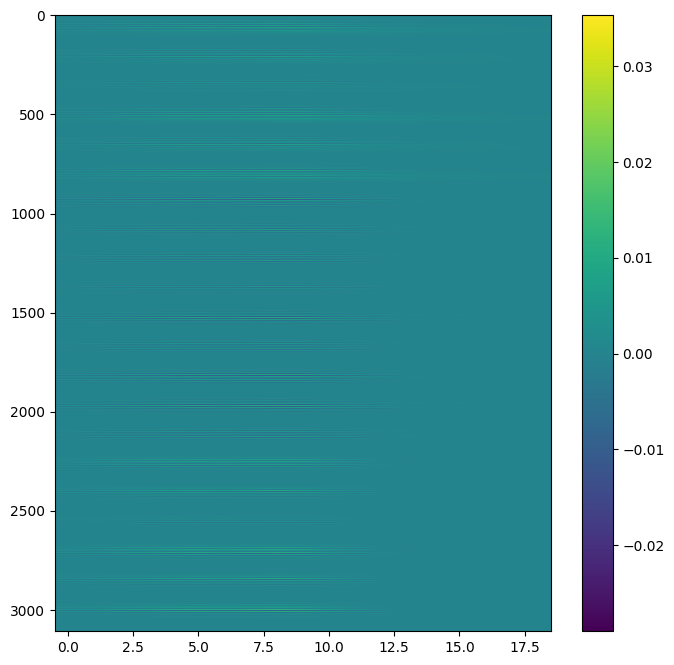

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(XCorr, aspect="auto")
plt.colorbar()
plt.show()

In [13]:
# Save cross-covariance in numpy and fits formats
np.save('products/XCov_mflike_lensing.npy', XCov_binned)

hdu = fits.PrimaryHDU(data=XCov_binned)
hdu.writeto("products/XCov_mflike_lensing.fits", overwrite=True)

# LSS cross-covariance ($\gamma$ x $\kappa$, CMB)

In [14]:
# Load relevant yaml file
info = yaml_load_file(yaml_folder+"run_shearkappa_fiducial.yaml")

# Need to update datapath because we are not loading the yaml file from the usual location
likelihood_name = 'soliket.cross_correlation.ShearKappaLikelihood'
datapath = Path(info['likelihood'][likelihood_name]['datapath'])
datapath = (yaml_path / datapath).resolve()
info['likelihood'][likelihood_name]['datapath'] = datapath

model = get_model(info)

sklike = model.likelihood[likelihood_name]

params_values = model.parameterization.input_params()
model.loglikes(params_values)


[camb] `camb` module loaded successfully from /mnt/lustre/users/astro/rk480/miniforge3/envs/pyccl-mpi/lib/python3.11/site-packages/camb


/its/home/rk480/.local/lib/python3.11/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value cl_20. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "


(array([543.99044525]),
 [2.111534442254061e-09,
  0.6874153841562113,
  0.3125057923039775,
  0.14323046728088973,
  0.8151600203847852,
  0.008660254037844387,
  0.05,
  0.05866025403784439])

In [15]:
# The whole cell is a copy/paste from cross_correlation.py 
# in order to compute the unbinned cross-correlations
ccl, cosmo = sklike._get_CCL_results()

cl_binned_list = []
cl_unbinned_list = []
w_bins_list = []
z = []
nz = []

for tracer_comb in sklike.sacc_data.get_tracer_combinations():
    sheartracer_name = tracer_comb[0]

    z_tracer1 = sklike.sacc_data.tracers[tracer_comb[0]].z
    nz_tracer1 = sklike.sacc_data.tracers[tracer_comb[0]].nz

    if sklike.ia_mode is None:
        ia_z = None
    elif sklike.ia_mode == "nla":
        A_IA = params_values["A_IA"]
        eta_IA = params_values["eta_IA"]
        z0_IA = trapezoid(z_tracer1 * nz_tracer1)

        ia_z = (z_tracer1, A_IA * ((1 + z_tracer1) / (1 + z0_IA)) ** eta_IA)
    elif sklike.ia_mode == "nla-perbin":
        A_IA = params_values[f"{sheartracer_name}_A_IA"]
        ia_z = (z_tracer1, A_IA * np.ones_like(z_tracer1))
    elif sklike.ia_mode == "nla-noevo":
        A_IA = params_values["A_IA"]
        ia_z = (z_tracer1, A_IA * np.ones_like(z_tracer1))

    tracer1 = ccl.WeakLensingTracer(
        cosmo, dndz=(z_tracer1, nz_tracer1), ia_bias=ia_z
    )

    if sklike.z_nuisance_mode is not None:
        nz_tracer1 = sklike._get_nz(
            z_tracer1, tracer1, tracer_comb[0], **params_values
        )

        tracer1 = ccl.WeakLensingTracer(
            cosmo, dndz=(z_tracer1, nz_tracer1), ia_bias=ia_z
        )
    z.append(z_tracer1)
    nz.append(nz_tracer1)

    tracer2 = ccl.CMBLensingTracer(
        cosmo, z_source=sklike.provider.get_param("zstar")
    )
    bpw_idx = sklike.sacc_data.indices(tracers=tracer_comb)
    bpw = sklike.sacc_data.get_bandpower_windows(bpw_idx)
    ells_theory = bpw.values
    ells_theory = np.asarray(ells_theory, dtype=int)
    w_bins = bpw.weight.T
    w_bins_list.append(w_bins)

    cl_unbinned = ccl.cells.angular_cl(cosmo, tracer1, tracer2, ells_theory)

    if sklike.m_nuisance_mode is not None:
        # note this allows wrong calculation, as we can do
        # shear x shear if the spectra are in the sacc
        # but then we would want (1 + m1) * (1 + m2)
        m_bias = params_values[f"{sheartracer_name}_m"]
        cl_unbinned = (1 + m_bias) * cl_unbinned

    cl_binned = np.dot(w_bins, cl_unbinned)

    cl_binned_list.append(cl_binned)
    cl_unbinned_list.append(cl_unbinned)

cl_binned_total = np.concatenate(cl_binned_list)
cl_unbinned_total = np.concatenate(cl_unbinned_list)

In [16]:
# Compute cross-covariance matrix 
# between l(l+1)/(2*pi)C_l^{TT,EE,TE} and C_l^{\gamma\kappa} 

XCov_binned = np.zeros((s.mean.size, len(sklike.y)))
lmax_lss = len(cl_unbinned_list[0])
ell_lss = np.arange(lmax_lss)

index_cmb = 0
for comb in s.get_tracer_combinations():
    (t1, t2) = comb
    if t1[-1] == "0" and t2[-1] == "0":
        # TT case
        ind = s.indices("cl_00", comb)
        ind_CAMB = 0
    elif t1[-1] == "2" and t2[-1] == "2":
        # EE case
        ind = s.indices("cl_ee", comb)
        ind_CAMB = 1
    else:
        # TE case
        ind = s.indices("cl_0e", comb)
        ind_CAMB = 3

    bpw = s.get_bandpower_windows(ind)
    w = bpw.weight.T

    # Compute cross-covariance
    XCov = []
    for k in range(len(cl_unbinned_list)):
        XCov.append(2/np.pi*dCllens[ind_CAMB, bpw.values, :lmax_lss]/clp[0:lmax_lss] \
                    *2*cl_unbinned_list[k]**2/(2*ell_lss+1)/fsky)
        XCov[k][:,0:2] = [0,0]

    # Bin cross-covariance
    for k in range(len(cl_unbinned_list)):
        w_k = w_bins_list[k]
        for j in range(len(w_k)):
            XCov_binned[index_cmb:index_cmb + len(w), k*len(w_k)+j] = \
                w @ np.sum(w_k[j] * XCov[k], axis=1)

    index_cmb += len(w)


In [17]:
XCorr = copy.deepcopy(XCov_binned)
for k in range(len(XCorr)):
    for j in range(len(XCorr[0])):
        XCorr[k,j] = XCov_binned[k,j]/np.sqrt(sklike.cov[j,j]*s.covariance.covmat[k,k])

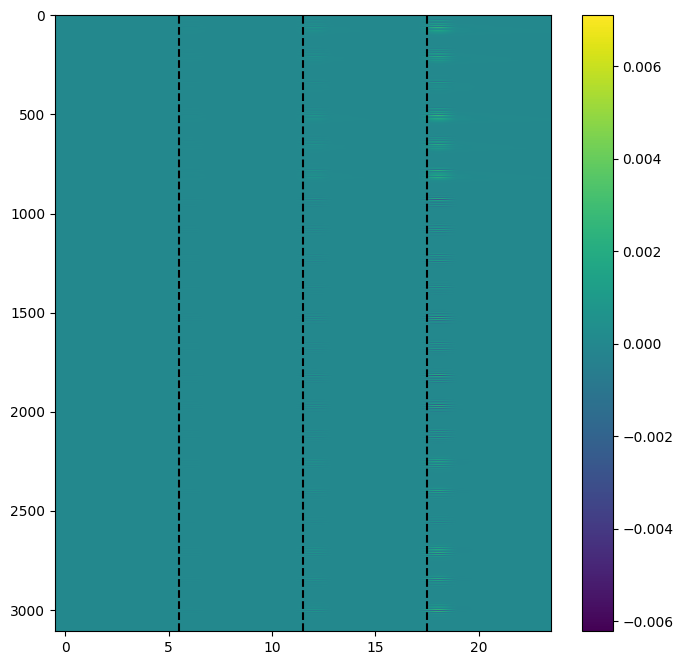

In [18]:
plt.figure(figsize=(8, 8))
plt.imshow(XCorr, aspect="auto")
for k in range(1,4):
    plt.axvline(x=k*len(w_bins_list[0])-0.5, ls='--', color='black')
plt.colorbar()
plt.show()

Text(0, 0.5, 'n(z)')

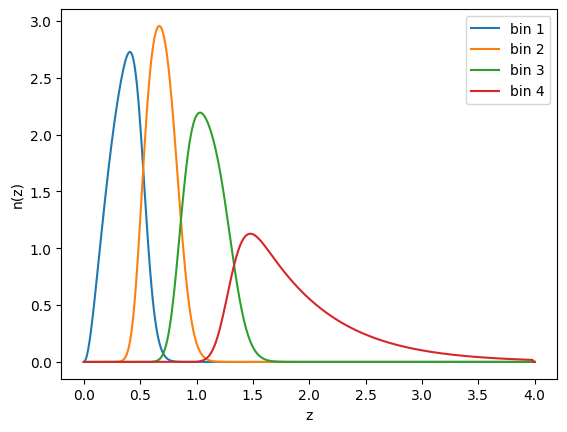

In [19]:
plt.figure()
for k in range(4):
    plt.plot(z[k],nz[k], label=f"bin {k+1}")
plt.legend()
plt.xlabel("z")
plt.ylabel("n(z)")

In [20]:
# Save cross-covariance in numpy and fits formats
np.save('products/XCov_mflike_shearkappa.npy', XCov_binned)

hdu = fits.PrimaryHDU(data=XCov_binned)
hdu.writeto("products/XCov_mflike_shearkappa.fits", overwrite=True)

# Lensing induced covariance in CMB primary block

In [21]:
# Computes the lensing induced covariance (introduces some mixing between different modes)
# Runs in about 4min

def f_ind_CAMB(comb):
    (t1, t2) = comb
    if t1[-1] == '0' and t2[-1] == '0':
        ind = s.indices('cl_00', comb)
        ind_CAMB = 0
    elif t1[-1] == '2' and t2[-1] == '2':
        ind = s.indices('cl_ee', comb)
        ind_CAMB = 1
    else:
        ind = s.indices('cl_0e', comb)
        ind_CAMB = 3
    return (ind, ind_CAMB)

Lensing_cov = np.zeros((s.mean.size, s.mean.size))
ell3 = np.arange(0, len(clp), 1)
factor = 2 / (2 * ell3 + 1) / fsky

comb = s.get_tracer_combinations()
num_comb = len(comb)

cached_data = [
    (f_ind_CAMB(comb[i]), s.get_bandpower_windows(f_ind_CAMB(comb[i])[0]))
    for i in range(num_comb)
]

time1 = time.time()
for index1 in range(num_comb):
    (ind1, ind_CAMB1), bpw1 = cached_data[index1]
    w1 = bpw1.weight.T
    for index2 in range(index1, num_comb):

        (ind2, ind_CAMB2), bpw2 = cached_data[index2]
        w2 = bpw2.weight.T

        A1 = w1 @ dCllens[ind_CAMB1, bpw1.values]
        A2 = w2 @ dCllens[ind_CAMB2, bpw2.values]
        product = (A1[:, np.newaxis] * A2[np.newaxis, :]) * factor

        Lensing_cov[index1 * len(w1):(index1 + 1) * len(w1),
                    index2 * len(w2):(index2 + 1) * len(w2)] = np.sum(product, axis=2)
time2 = time.time()
print(time2-time1)

224.31177639961243


In [22]:
Lensing_cov_upper_diag = np.triu(Lensing_cov, 0)
Lensing_cov_upper = np.triu(Lensing_cov, 1)
Lensing_cov_full = Lensing_cov_upper_diag + Lensing_cov_upper.T

In [23]:
# Save lensing induced covariance
np.save('products/Lensing_cov.npy', Lensing_cov_full)

hdu = fits.PrimaryHDU(data=Lensing_cov_full)
hdu.writeto("products/Lensing_cov.fits", overwrite=True)

In [24]:
XCorr = copy.deepcopy(Lensing_cov_full)
for k in range(len(XCorr)):
    for j in range(len(XCorr[0])):
        XCorr[k,j] = Lensing_cov_full[k,j] \
                        /np.sqrt(s.covariance.covmat[j,j]*s.covariance.covmat[k,k])

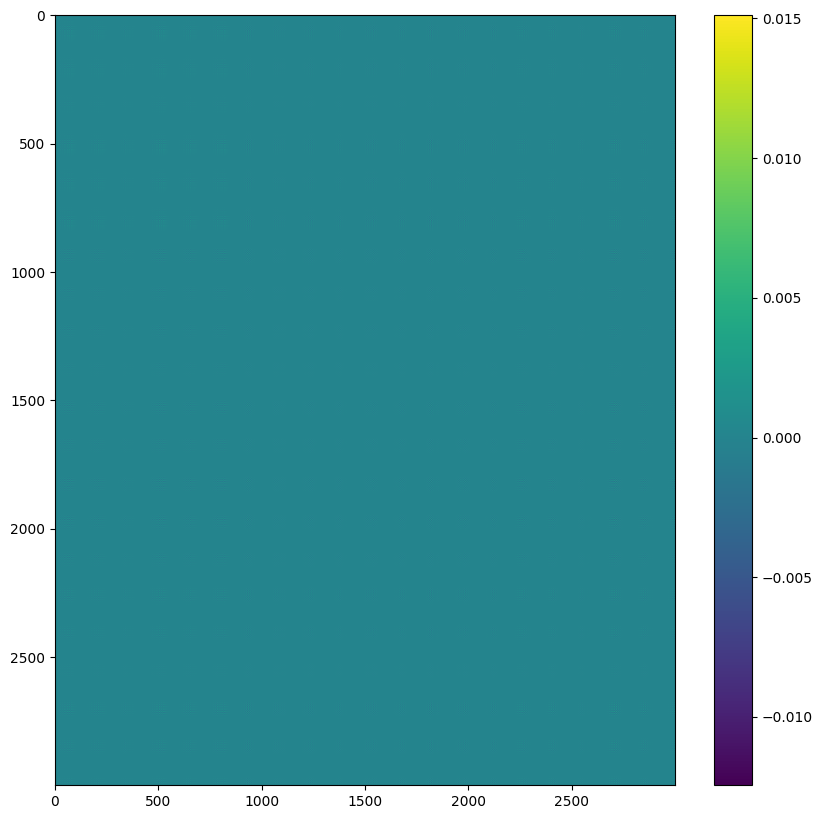

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(XCorr[0:3000,0:3000], aspect='auto')
plt.colorbar()

# Test impact of N1 bias on the cross-covariance

In [26]:
# Computes the N1 bias curve. Warning: this cell is very long (almost 1h)
# Much of the following cells has been copy/pasted from demo notebook of lensitbiases
import lensitbiases as lb
from lensitbiases import n0_fft, n1_fft, utils_n1
from scipy import signal
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.interpolate import UnivariateSpline as spl

lminbox=20
cls_unl, cls_len, cls_grad = lb.get_default_cls() 

estimator = 'p'


nTf = np.loadtxt('../data/SO_LAT_Nell_T_atmv1_baseline_fsky0p4_ILC_CMB.txt')
nPf = np.loadtxt('../data/SO_LAT_Nell_P_baseline_fsky0p4_ILC_CMB_E.txt')
nlevT = (np.sqrt(np.concatenate((np.zeros(40),nTf[:,1]))) *60 * 180/np.pi)[:4000+1]
nlevP = (np.sqrt(np.concatenate((np.zeros(40),nPf[:,1]))) *60 * 180/np.pi)[:4000+1]

fal = utils_n1.get_fal(clscmb_filt=cls_len, clscmb_dat=cls_len, beam=0,
                   lmin_ivf=100, lmax_ivf=4000, nlevt=nlevT, nlevp=nlevP, jt_tp=False)[1]

lib_n1 = n1_fft.n1_fft(fal, 
                       cls_len, 
                       cls_grad, 
                       cls_unl['pp'], 
                       lminbox=lminbox, 
                       lmaxbox=2500*2
                      ) 

Ls_n1 = np.arange(lminbox, 4000+1, 1, dtype=np.int64) #np.linspace(lminbox, 2*2048, 10)

res = [lib_n1.get_n1(estimator, L, do_n1mat=True) for L in Ls_n1]

n1_SOlike = np.array([r[0] for r in res])
n1_mat = np.array([r[1] for r in res]) 

(R_gg, R_cc), Ls_r = n0_fft.nhl_fft(fal, 
                                    cls_grad, 
                                    lminbox=lminbox, 
                                    lmaxbox=5000
                                   ).get_nhl(estimator)
normalization = 1/spl(Ls_r, R_gg, k=2, s=0, ext='zeros')(Ls_n1) ** 2

In [27]:
def gaussian_smooth_1d(data, sigma, nsigma=5):
    win = signal.windows.gaussian(nsigma * sigma, std=sigma)
    res = np.convolve(data, win, mode='same')
    return res / np.convolve(np.ones(data.shape), win, mode='same')

a=np.arange(n1_mat.shape[1], dtype=np.int64)
nonzero =a[n1_mat[62,:]!=0]
diffs = np.concatenate(([10],(nonzero[2:] - nonzero[:-2])/2,[10]))
scaled = n1_mat.copy()
scaled[:,nonzero] = n1_mat[:,nonzero]/diffs
sc = clp[:n1_mat.shape[1]]/(a*(a+1))**2
sc[:2]=1
N1_mat_smoothed = scaled.copy()
for i, L in enumerate(Ls_n1):
    N1_mat_smoothed[i,:] = spline(nonzero, 
                                  gaussian_smooth_1d(scaled[i,nonzero]*sc[nonzero],20)
                                 )(a) / sc


In [28]:
fac = (a*(a+1))**2/2/np.pi
fac[0]=1
minl = min(n1_mat.shape[1], cls_unl['pp'].shape[0])

# define n1_normed_mat_smoothed which acts on and returns [L(L+1)]^2/2-like quantities

n1_normed_mat_smoothed = fac[Ls_n1,np.newaxis]*normalization[:,np.newaxis] \
                            *N1_mat_smoothed / fac

In [29]:
np.save("products/n1_normed_mat_smoothed.npy", n1_normed_mat_smoothed)

In [30]:
def f_ind_CAMB(comb):
    (t1, t2) = comb
    if t1[-1] == '0' and t2[-1] == '0':
        ind = s.indices('cl_00', comb)
        ind_CAMB = 0
    elif t1[-1] == '2' and t2[-1] == '2':
        ind = s.indices('cl_ee', comb)
        ind_CAMB = 1
    else:
        ind = s.indices('cl_0e', comb)
        ind_CAMB = 3
    return (ind, ind_CAMB)

XCov_N1 = np.zeros((s.mean.size,nb_bins_kk))
ell3 = np.arange(0, n1_normed_mat_smoothed.shape[1], 1)
factor = 2 * clp[0:n1_normed_mat_smoothed.shape[1]] / (2 * ell3 + 1) / fsky
factor[1:] *= (2*np.pi) / (ell3[1:]*(ell3[1:]+1))**2

comb = s.get_tracer_combinations()
num_comb = len(comb)

cached_data = [
    (f_ind_CAMB(comb[i]), s.get_bandpower_windows(f_ind_CAMB(comb[i])[0]))
    for i in range(num_comb)
]

time1 = time.time()
for index1 in range(num_comb):
    (ind1, ind_CAMB1), bpw1 = cached_data[index1]
    w1 = bpw1.weight.T

    A1 = w1 @ dCllens[ind_CAMB1, bpw1.values]
    A2 = lenslike.binning_matrix @ n1_normed_mat_smoothed[0:lmax_kk,:]*np.pi/2.
    product = (A1[:, np.newaxis, 0:n1_normed_mat_smoothed.shape[1]] * A2[np.newaxis, :]) \
                * factor

    XCov_N1[index1 * len(w1):(index1 + 1) * len(w1),:] = np.sum(product, axis=2)
time2 = time.time()
print(time2-time1)

10.036860466003418


In [31]:
np.save('products/XCov_mflike_lensing_N1.npy', XCov_N1)

hdu = fits.PrimaryHDU(data=XCov_N1)
hdu.writeto("products/XCov_mflike_lensing_N1.fits", overwrite=True)

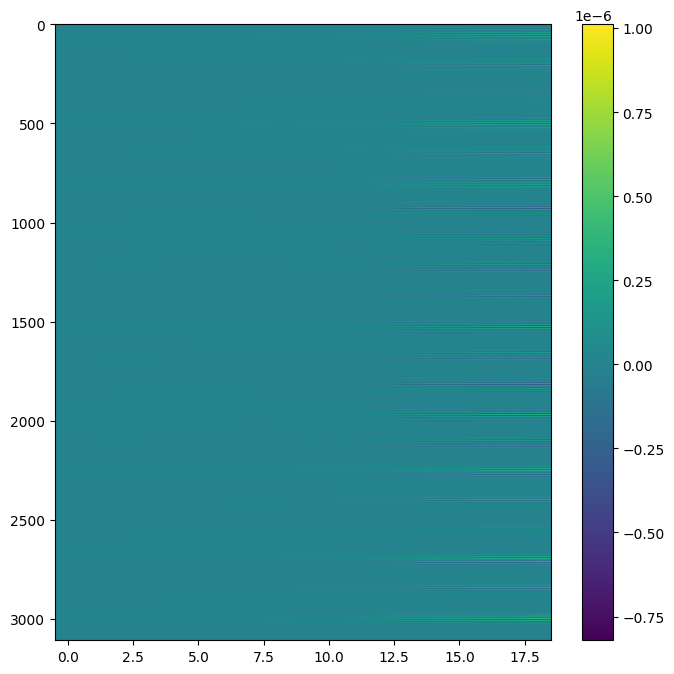

In [32]:
# Plot correlation cross-covariance due to N1
XCorr = copy.deepcopy(XCov_N1)
for k in range(len(XCorr)):
    for j in range(len(XCorr[0])):
        XCorr[k,j] = XCov_N1[k,j]/np.sqrt(lenslike.cov[j,j]*s.covariance.covmat[k,k])
plt.figure(figsize=(8,8))
plt.imshow(XCorr, aspect='auto')
plt.colorbar()